# Global Fishing Watch Exploratory Data Analysis

Questions to answer in this script:

Unit of analysis: Ship or ship-year or ship-cruise?
- How long is a cruise for a reefer? 
- Does behaviour change over time?

Fishing vessels:
- Do fishing vessels that have met a bad reefer always meet with bad reefers? --> Can we partition fishing boats in good and bad? 
- How do bad fishing boats differ from good fishing boats? What are characteristics of bad fishers? 
    - flags
    - size
    - time at sea
    - age

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Importing data 

In [88]:
def import_data():
    path = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/xlsx/gfw_data-v2.xlsx'
    xls = pd.ExcelFile(path)
    dfList = []
    for sheet in ['carriers', 'encounter-v2', 'loitering-v2', 'carrier_port_visit-v2']:
        dfList.append(pd.read_excel(path, sheet_name=sheet))
    return dfList

In [ ]:
dfList = import_data()

In [ ]:
port_visits = dfList[3]
carriers = dfList[0]
encounter = dfList[1]
loitering = dfList[2]

In [90]:
num_encounter = []
num_loitering = []
for i in carriers.id:
    num_encounter.append(encounter[encounter['vessel.id']==i].shape[0])
    num_loitering.append(loitering[loitering['vessel.id']==i].shape[0])

# append the num info into new column in carrier table
carrier = carriers.assign(encounter=num_encounter, loitering = num_loitering)

In [91]:
psma_entry = pd.read_excel(
    '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/Law_Review/Law Review2.xlsx',
    sheet_name = 'PSMA'
)
psma_entry.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace = True)
psma_entry.columns = ['Country', 'Signature', 'Ratification', 'Status']
psma_entry['rat_year'] = psma_entry['Ratification'].str[:4].fillna(0).astype(int)
psma_entry['rat_year'] = psma_entry['rat_year'].replace(0,np.nan)
psma_entry

,Country,Signature,Ratification,Status,rat_year
0,ALB,NaT,2017-04-07 ACS,False,2017.0
1,AGO,2009-11-22,2022-07-20 ACS,False,2022.0
2,AUS,2010-04-27,2015-07-20 RAT,True,2015.0
3,BHS,NaT,2016-10-07 ACS,False,2016.0
4,BGD,NaT,2019-12-20 ACS,False,2019.0
...,...,...,...,...,...
69,GBR,NaT,2021-01-31 ACS,False,2021.0
70,USA,2009-11-22,2016-02-26 RAT,True,2016.0
71,URY,2009-11-22,2013-02-28 RAT,True,2013.0
72,VUT,NaT,2016-05-06 ACS,False,2016.0


In [92]:
loitering['year'] = loitering['end'].str[:4].astype(int)
loit = loitering.merge(psma_entry, left_on='vessel.flag', right_on='Country', how='left')
loit['years_after_psma'] = loit['rat_year'] - loit['year'] 

In [93]:
# of all times
top_perps = loitering.groupby(['vessel.flag'])['id'].count().reset_index().sort_values('id').tail(10)
top_perps

,vessel.flag,id
35,JPN,5465
31,IDN,5775
3,BHS,5860
39,KOR,6867
76,VUT,7455
71,TWN,9289
40,LBR,11613
10,CHN,21666
54,PAN,52011
59,RUS,74092


In [94]:
# per year
loitering_per_year = loitering.groupby(['vessel.flag', 'year'])['id'].count().reset_index()
loitering_per_year

,vessel.flag,year,id
0,ATG,2012,5
1,ATG,2013,6
2,ATG,2014,3
3,ATG,2016,2
4,ATG,2017,2
...,...,...,...
520,VUT,2019,129
521,VUT,2020,155
522,VUT,2021,64
523,WSM,2018,8


In [95]:
loitering_per_psma = loit.groupby(['years_after_psma'])['id'].count().reset_index()
loitering_per_psma['years_after_psma'] = loitering_per_psma['years_after_psma'].astype(int)

<AxesSubplot: xlabel='years_after_psma', ylabel='id'>

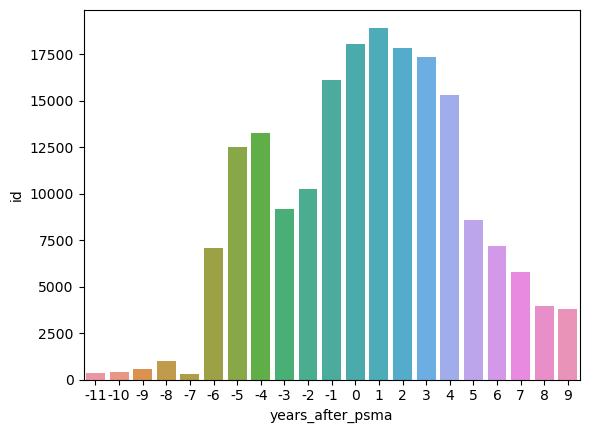

In [96]:
sns.barplot(loitering_per_psma, x ='years_after_psma', y='id')

In [97]:
loitering_per_psma = loit.groupby(['years_after_psma', 'vessel.flag'])['id'].count().reset_index()
loitering_per_psma['years_after_psma'] = loitering_per_psma['years_after_psma'].astype(int)
loitering_per_psma['id_log'] = np.log10(loitering_per_psma['id'])

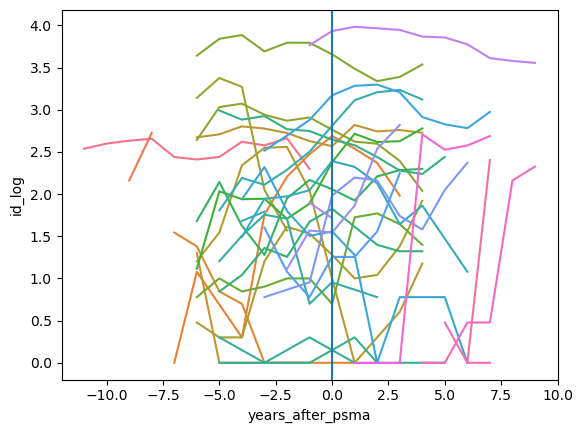

In [98]:
sns.lineplot(loitering_per_psma, x ='years_after_psma', y='id_log', hue='vessel.flag', legend=False)
plt.axvline(0, 0,1)

In [99]:
loitering_per_psma_filtered = loitering_per_psma[loitering_per_psma['vessel.flag'].isin(top_perps['vessel.flag'])]

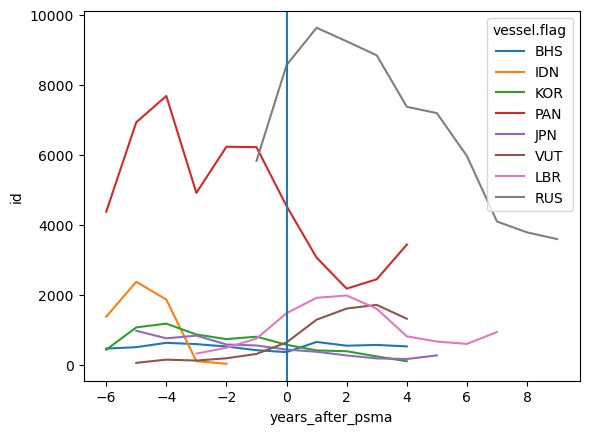

In [100]:
sns.lineplot(loitering_per_psma_filtered, x ='years_after_psma', y='id', hue='vessel.flag')
plt.axvline(0, 0,1)

## Port visits

In [102]:
port_visits['year'] = port_visits['end'].str[:4].astype(int)
ports = port_visits.merge(psma_entry, left_on='vessel.flag', right_on='Country', how='left')
ports['years_after_psma'] = ports['rat_year'] - loit['year'] 

In [105]:
top_perps = ports.groupby(['port.country'])['id'].count().reset_index().sort_values('id').tail(10)
top_perps

,port.country,id
119,PAN,17238
42,ESP,21647
84,KOR,23501
158,TUR,23862
21,CHN,24753
80,JPN,33474
114,NOR,44427
20,CHL,51513
132,RUS,67276
164,USA,141518


In [112]:
ports_per_year = port_visits.groupby(['port.country', 'year'])['id'].count().reset_index()
ports_per_year

,port.country,year,id
0,ABW,2012,21
1,ABW,2013,39
2,ABW,2014,61
3,ABW,2015,51
4,ABW,2016,62
...,...,...,...
1608,ZAF,2018,437
1609,ZAF,2019,365
1610,ZAF,2020,334
1611,ZAF,2021,325


In [113]:
ports_psma = ports.groupby(['years_after_psma'])['id'].count().reset_index()
ports_psma['years_after_psma'] = ports_psma['years_after_psma'].astype(int)

<AxesSubplot: xlabel='years_after_psma', ylabel='id'>

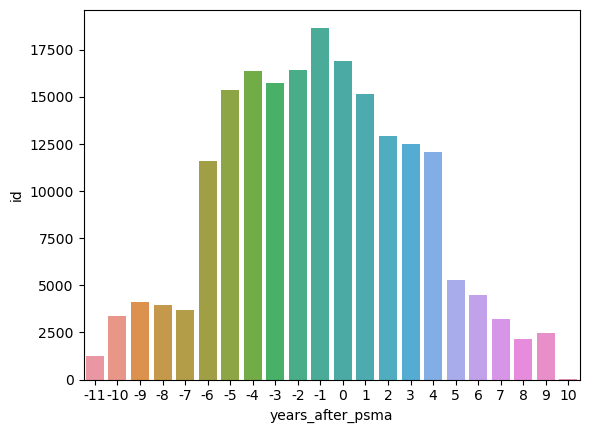

In [114]:
sns.barplot(ports_psma, x ='years_after_psma', y='id')

In [115]:
ports_psma2 = ports.groupby(['years_after_psma', 'port.country'])['id'].count().reset_index()
ports_psma2['years_after_psma'] = ports_psma2['years_after_psma'].astype(int)
ports_psma2['id_log'] = np.log10(ports_psma2['id'])

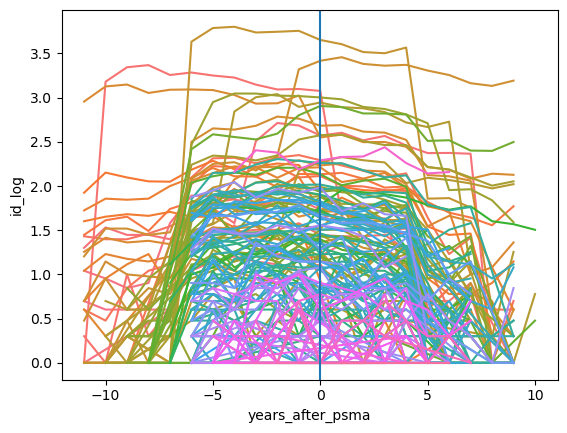

In [116]:
sns.lineplot(ports_psma2, x ='years_after_psma', y='id_log', hue='port.country', legend=False)
plt.axvline(0, 0,1)

In [117]:
ports_psma_filt = ports_psma2[ports_psma2['port.country'].isin(top_perps['port.country'])]

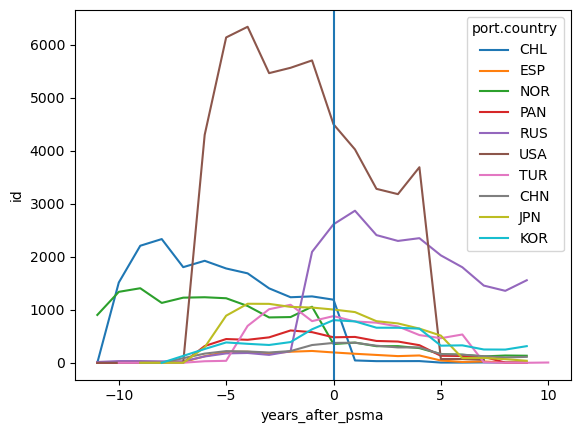

In [119]:
sns.lineplot(ports_psma_filt, x ='years_after_psma', y='id', hue='port.country')
plt.axvline(0, 0,1)

In [ ]:
## possible additions: 
## relative in percent to ratification year
## relative to total loiterings and port visits in the respective year